In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import pandas_datareader as pdr
from yahoo_fin import stock_info as si
from scipy.stats import shapiro
from yahoofinancials import *

In [2]:
def preparar_datos(datos):
    
    # Lo primero es seleccionar las columnas que contienen los datos que nos interesan
    d = pd.read_csv(datos, index_col=0, usecols=[0,2,6]).dropna()
    # 
    d['firstTradeDate'] = d['firstTradeDate'].apply(lambda x: eval(x))
    d['prices'] = d['prices'].apply(lambda x: eval(x))
    #Extrae desde los objetos que están en la columna firstTradeDate solo el datos que nos interesa que es: 'formatted_date'
    d['firstTradeDate'] = d['firstTradeDate'].apply(lambda x: x['formatted_date'])
    #Crea una columna cuyos valores serán diccionarios compuestos de las fechas como clave y los precios como valor
    d['adjclose'] = d['prices'].apply(lambda x: {item['formatted_date']:item['adjclose'] for item in x})
    #d = d[d['firstTradeDate']<ini]
    #Crea una columna para cada fecha contenida en 'adjclose' donde sus valores serán sus precios respectivos
    fechas = list(d['adjclose'][0].keys())
    for fecha in fechas:
        d[fecha] = d.adjclose.apply(lambda x: x[fecha] if fecha in x else np.nan)
    # una vez extraído y separado en columnas los datos relevantes que vamos a analizar, descartamos las columnas procesadas
    data = d.T.drop(['firstTradeDate', 'prices', 'adjclose'])
    data.index.name = 'Fecha'
    return data, d.firstTradeDate

def calcular_acciones(data, base, ini, med, med2, fin):
    
    # seleccionamos el rango de fechas a analizar por defecto todo el rango
    data1 = data[ini:med]
    # Haciendo los cálculos de retornos, volatilidades y ratio sharpe
    rets = data1/data1.shift(1)-1
    r_anual = rets.mean()*252
    v_anual = rets.std()*np.sqrt(252)
    sharpe = r_anual/v_anual
    feb20 = data1.loc[med]
    pmax = data1.max()
    # Formando un DataFrame con los resultados
    pd.options.display.float_format = '{:,.2f}'.format
    df = pd.DataFrame([r_anual, sharpe, feb20, pmax],['$\mu$', 'Sharpe', 'feb20', 'pmax'])
    df.loc['Sharpe'] = df.loc['Sharpe'].map('{:.5f}'.format).astype(float)
    df = df.T
    df.index.name = 'Symbol'
    
    # seleccionamos el rango de fechas a analizar por defecto todo el rango
    data2 = data[med2:fin]
    # Haciendo los cálculos de retornos, volatilidades y ratio sharpe
    rets2 = data2/data2.shift(1)-1
    r_anual2 = rets2.mean()*252
    v_anual2 = rets2.std()*np.sqrt(252)
    sharpe2 = r_anual2/v_anual2
    pmax2 = data2.max()
    pmin2 = data2.min()
    sd = data2.std()

    # Formando un DataFrame con los resultados
    #pd.options.display.float_format = '{:,.2f}'.format
    df2 = pd.DataFrame([r_anual2, sharpe2, sd, pmin2, pmax2],['$\mu_2$', 'Sharpe2', 'sd', 'pmin2', 'pmax2'])
    df2.loc['Sharpe2'] = df2.loc['Sharpe2'].map('{:.5f}'.format).astype(float)
    df2 = df2.T
    df2.index.name = 'Symbol' 
    
    
    # Cargando el archivo con la información base
    base = pd.read_csv(base)
    base.rename(index=str, columns={"Market Cap": "MarketCap", "Div Yield":"Div", "EPS ttm": "BPA", "P/E (ttm)": "PER", "Price/Book": "P/B", "ROE%": "ROE", "ROA%": "ROA", "Debt/Equity": "D/E"}, inplace=True)
    base['MarketCap'] = (base['MarketCap'] / 10**6)
    #df2.loc['$Sharpe$'] = df2.loc['$Sharpe$']
    # Uniendo los 2 DataFrames
    full = pd.merge(df, df2, on='Symbol')
    full = pd.merge(full, base, on='Symbol')
    #Ordenando los datos en función del ratio Sharpe en forma descendente
    full.sort_values('Sharpe2', ascending=False, inplace=True)
    
    full.set_index('Symbol', inplace=True)
    
    
    return full

## Cargando los datos

In [3]:
#Precios
precios = pd.read_excel('prices.xlsx', index_col=0)

#Fecha de inicio en bolsa
firstTrade =  pd.read_excel('first_trade.xlsx')
firstTrade.firstTradeDate = firstTrade.firstTradeDate.astype('datetime64')

#Datos fundamentales y descriptivos
base = 'full.csv'

# Consultas de escenarios

### Acciones que todavia no recuperan su maximo nivel de antes de la pandemia

#### Configuración

In [4]:
ini = '2017-02-01'
med = '2020-12-30' # Inicio de la debacle en bolsa
#med2 = '2020-03-23' # Fin de la debacle en bolsa
med2 = '2021-01-04'
#fin = date.today().strftime('%Y-%m-%d')
fin = '2021-03-19'

df = calcular_acciones(precios, base, ini, med, med2, fin)
df = pd.merge(df, firstTrade, on='Symbol').set_index('Symbol')

#### Filtro
df[(df['Sharpe']>1.0) & (df['pmax2']/df['feb20']<0.5)]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,


In [5]:
df[(df['Sharpe']<-1) & (df['Sharpe2']>1.5)]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
PCT,-0.20,-3.71,NaN,10.00,15.10,9.44,2.09,28.90,32.69,Purecycle Technologies Inc,...,"2,985.29",0.00,0.00,0.00,46.85,-0.28,-0.02,0.00,0.00,2020-07-14
IMNM,-1.13,-1.50,9.56,14.16,8.60,3.63,9.64,9.56,43.24,Immunome Inc,...,344.64,0.00,-2.94,0.00,7.86,0.00,0.00,NaN,0.00,2020-10-02
AAN,-3.78,-4.58,18.05,26.40,1.72,3.10,2.45,16.88,26.73,Aarons Holdings Company Inc,...,889.67,0.02,0.79,0.00,1.20,0.00,0.00,NaN,-15.33,2020-11-25
TOPS,-2.66,-1.19,1.20,"289,800,000.00",4.33,2.73,0.55,1.23,3.69,Top Ships Inc,...,79.27,0.00,0.00,0.00,0.61,0.00,0.00,NaN,-22.35,2004-08-02
OCG,-2.96,-1.92,5.11,7.33,8.29,2.44,1.68,3.02,11.43,Oriental Culture Holding Ltd,...,159.81,0.00,0.00,0.00,NaN,0.00,0.00,NaN,67.57,2020-12-15
AUVI,-1.76,-1.36,4.91,11.60,11.59,1.84,3.27,4.57,19.71,Applied Uv Inc,...,79.29,0.00,-0.14,0.00,11.19,0.00,0.00,0.02,-58.76,2020-08-31
BFI,-1.42,-2.12,14.25,18.55,0.97,1.64,1.07,12.17,16.38,Burgerfi Intl Inc,...,121.48,0.00,-0.13,0.00,2.67,0.00,0.00,0.06,0.00,2018-03-26


In [6]:
df[df['pmax'] / df['Last'] > 2]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
MCS,-0.01,-0.02,13.46,43.70,2.83,6.96,2.90,12.77,23.94,Marcus Corp,...,634.59,0.00,-4.13,0.00,1.23,-0.23,-0.09,0.41,-52.52,1980-03-17
NM,-0.17,-0.20,2.21,20.40,9.60,6.36,2.30,2.21,12.53,Navios Maritime Holdings Inc,...,143.87,0.00,-2.49,0.00,1.84,0.00,0.00,23.93,-38.47,2005-01-06
FARM,-0.38,-0.68,4.44,37.00,4.67,5.58,1.52,4.53,11.02,Farmer Brothers,...,189.62,0.00,-0.98,0.00,1.62,-0.14,-0.04,0.67,-7.40,1980-03-17
FPH,-0.16,-0.32,5.44,16.45,1.99,5.53,0.48,5.30,7.88,Five Point Holdings Llc Cl A,...,"1,124.74",0.00,-0.01,0.00,0.60,0.00,0.00,0.00,-0.28,2017-05-10
CSU,-0.37,-0.39,12.23,261.00,7.11,5.47,8.41,11.59,45.18,Capital Senior Living Corp,...,83.91,0.00,-56.37,0.00,NaN,0.00,-0.13,NaN,-8.06,1997-10-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BLI,1.03,1.36,92.00,106.00,-2.41,-3.94,12.70,47.82,89.26,Berkeley Lights Inc,...,"3,170.79",0.00,-4.60,0.00,11.66,0.00,0.00,0.05,-64.67,2020-07-17
ONCR,3.23,3.64,31.85,35.15,-3.37,-4.25,6.44,13.91,35.55,Oncorus Inc,...,360.03,0.00,-11.97,0.00,2.08,0.00,0.00,NaN,0.00,2020-10-02
HPK,0.98,0.96,15.77,19.30,-3.89,-4.34,3.83,6.54,18.99,Highpeak Energy Inc,...,634.83,0.00,-0.05,0.00,1.17,-0.07,-0.05,0.00,-412.10,2018-05-29


In [7]:
df[(df['feb20']/df['Last']>3) & (df['sd']<1) & (df['pmax2']/df['pmin2']<1.7)]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,


In [8]:
df[(df['MarketCap']>100000)].sort_values('Sharpe2', ascending = False).head(20)

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
GS,0.10,0.31,258.43,258.57,1.33,4.57,24.08,263.96,348.81,Goldman Sachs Group,...,"113,296.00",0.02,31.13,10.50,1.35,0.14,0.01,2.63,21.23,1999-05-04
TD,0.09,0.37,55.83,56.23,0.83,4.44,2.93,55.66,66.31,Toronto Dominion Bank,...,"119,554.00",0.04,4.17,15.64,1.70,0.12,0.01,0.13,22.16,1996-08-30
JPM,0.18,0.56,124.46,135.17,1.08,4.41,9.26,124.97,157.65,JP Morgan Chase & Company,...,"469,047.00",0.02,8.87,17.16,1.89,0.12,0.01,1.16,22.49,1980-03-17
DE,0.30,0.95,265.50,269.26,1.68,4.27,30.34,266.99,379.48,Deere & Company,...,"116,637.00",0.01,10.94,34.20,8.32,0.27,0.05,2.53,7.74,1972-06-01
BAC,0.15,0.43,29.83,34.54,1.28,4.21,2.61,29.50,38.94,Bank of America Corp,...,"340,690.00",0.02,1.87,20.69,1.36,0.07,0.01,1.04,19.09,1973-02-21
RY,0.10,0.45,81.07,82.51,0.71,4.15,3.80,80.82,93.73,Royal Bank of Canada,...,"131,735.00",0.04,6.21,14.85,2.05,0.15,0.01,0.12,18.67,1995-10-16
WFC,-0.06,-0.18,29.66,59.02,1.50,3.63,3.28,29.61,40.81,Wells Fargo & Company,...,"163,836.00",0.01,0.55,71.04,0.99,0.02,0.00,1.34,4.11,1972-06-01
CAT,0.24,0.74,179.09,181.25,1.11,3.51,15.45,180.63,233.63,Caterpillar Inc,...,"126,914.00",0.02,6.09,38.07,8.27,0.23,0.04,1.74,7.18,1962-01-02
MS,0.21,0.58,67.49,67.86,1.01,3.43,4.75,67.05,84.34,Morgan Stanley,...,"141,723.00",0.02,6.54,11.87,1.53,0.13,0.01,2.50,22.81,1993-02-23


### Acciones con buena tendencia antes y después de la debacle en bolsa

In [9]:
df[(df['Sharpe']>1.0) & (df['Sharpe2']>1.5) & (df['PER'].apply(lambda x: (x>5) & (x<30))) & (df['MarketCap']>500)]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
RCII,0.50,1.06,38.38,39.69,2.41,4.73,6.82,38.14,64.25,Rent-A-Center Inc,...,"3,209.34",0.02,3.54,16.29,5.32,0.38,0.12,0.35,7.40,1995-01-25
ONEW,1.25,1.18,27.77,30.82,1.73,3.56,3.24,29.65,44.10,Onewater Marine Inc Cl A,...,625.96,0.00,4.15,9.63,3.19,0.18,0.06,0.47,1.70,2020-02-07
CROX,0.72,1.23,62.58,65.63,1.24,2.30,4.99,61.56,84.80,Crocs Inc,...,"5,206.41",0.00,3.23,24.91,18.04,1.15,0.25,0.59,22.57,2006-02-08
DECK,0.50,1.19,286.00,304.27,0.95,2.29,13.59,278.61,344.13,Deckers Outdoor Corp,...,"9,310.75",0.00,12.86,25.69,6.04,0.29,0.18,0.02,12.95,1993-10-15
APG,0.87,2.34,17.85,17.94,0.73,2.28,1.01,16.87,20.56,Api Group Corp,...,"4,334.08",0.00,1.18,17.53,2.18,0.28,0.11,0.73,-4.27,2020-04-29
MED,0.56,1.05,191.70,235.71,1.16,2.28,21.27,191.38,272.57,Medifast Inc,...,"2,617.36",0.03,9.16,23.12,15.99,0.83,0.45,0.00,11.00,1993-12-30
HZNP,0.50,1.02,72.34,84.39,1.18,2.06,6.48,71.83,95.48,Horizon Therapeutics,...,"20,278.70",0.00,3.89,23.66,4.78,0.28,0.17,0.26,17.71,2011-07-28
CARR,1.67,2.59,37.73,40.37,0.55,1.50,1.61,35.52,41.74,Carrier Global Corp,...,"36,527.32",0.01,1.66,25.43,5.58,0.30,0.06,2.16,11.35,2020-03-19


### Acciones que subieron en la debacle

#### Configuración

In [10]:
ini = '2020-02-20' # Inicio de la debacle en bolsa
med = '2020-03-23' # Fin de la debacle en bolsa
med2 = '2020-03-24' 
#fin = date.today().strftime('%Y-%m-%d')
fin = '2020-11-27'

df = calcular_acciones(precios, base, ini, med, med2, fin)
df = pd.merge(df, firstTrade, on='Symbol').set_index('Symbol')

df[(df['Sharpe2']>2) & (df['Last']<2)]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
LPCN,1.06,0.37,0.39,0.77,2.41,2.62,0.45,0.40,2.23,Lipocine Inc,...,136.85,0.00,-0.40,0.00,7.71,-1.69,-0.89,0.22,0.00,2013-10-22
TRVN,-2.60,-3.07,0.60,0.81,2.67,2.55,0.79,0.47,3.26,Trevena Inc,...,299.97,0.00,-0.24,0.00,2.73,-0.39,-0.33,0.00,-956.68,2014-01-31
KOR,-5.99,-5.69,0.98,1.77,1.41,2.00,0.60,0.94,3.10,Corvus Gold Inc,...,239.68,0.00,-0.11,0.00,24.30,-1.19,-1.11,0.00,0.00,2010-10-18


In [11]:
df[(df['Sharpe2'] > 2) & (df['PER'].apply(lambda x: (x>5) & (x<25)))][:10]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
TFII,-7.81,-7.72,16.73,35.01,1.49,3.91,9.24,19.24,52.18,Tfi International Inc,...,"7,165.32",0.01,3.30,22.65,3.82,0.19,0.08,0.46,7.29,2005-11-15
GRVY,-2.30,-2.75,23.00,31.72,3.04,3.78,38.07,25.16,162.46,Gravity CO Ltd,...,854.78,0.00,5.80,19.83,5.57,0.00,0.00,0.00,11.05,2005-02-08
AVNW,-6.31,-7.04,7.40,13.45,2.50,3.54,5.88,7.57,35.73,Aviat Networks Inc,...,429.09,0.00,3.86,18.40,4.45,0.29,0.12,0.00,0.11,1987-05-19
LMB,-5.17,-4.60,2.53,4.54,2.43,3.46,2.87,2.65,11.98,Limbach Holdings Inc,...,106.17,0.00,0.77,13.71,1.44,0.12,0.02,0.71,1.02,2014-08-08
NLS,-11.21,-8.12,1.29,3.84,4.58,3.45,6.67,1.45,27.80,Nautilus Group,...,494.53,0.00,2.48,6.31,3.01,0.69,0.31,0.09,10.83,1999-05-05
TUP,-11.82,-4.61,1.53,6.25,5.74,3.43,10.59,1.37,36.68,Tupperware Corp,...,"1,313.71",0.00,2.27,11.63,NaN,-0.43,0.10,NaN,6.45,1996-05-08
LL,-6.69,-3.36,4.47,10.50,2.78,3.39,8.16,4.12,30.70,Lumber Liquidators Holdings Inc,...,756.60,0.00,2.27,11.07,3.21,0.35,0.10,0.52,5.60,2007-11-09
HIBB,-11.00,-7.49,7.94,23.57,2.38,3.39,12.01,9.71,55.40,Hibbett Sports Inc,...,"1,152.73",0.00,6.11,11.27,3.01,0.29,0.13,0.01,5.23,1996-10-11
MED,-6.48,-8.93,53.37,97.02,1.87,3.37,40.16,55.66,203.91,Medifast Inc,...,"2,617.36",0.03,9.16,23.12,15.99,0.83,0.45,0.00,11.00,1993-12-30


In [12]:
def categorias(ticker, df):
    cia = df.loc[ticker]
    
    if cia['SIC Description'] in df['SIC Description'].dropna().values:
        return pd.DataFrame({'Nombre de Categoria':[cia['Sector'], cia['Industry'], cia['SIC Description']], 
                  'Cantidad':[df.groupby('Sector').size()[cia['Sector']], 
                              df.groupby('Industry').size()[cia['Industry']], 
                              df.groupby('SIC Description').size()[cia['SIC Description']]]},
                  index = ['Sector', 'Industria', 'SIC'])
    else:
        return pd.DataFrame({'Nombre de Categoria':[cia['Sector'], cia['Industry'], 'ND'], 
                  'Cantidad':[df.groupby('Sector').size()[cia['Sector']], 
                              df.groupby('Industry').size()[cia['Industry']], 
                              'ND']},
                  index = ['Sector', 'Industria', 'SIC'])
        
    
   

def comparar_empresa(ticker, df):
    cia = df.loc[ticker]
    if cia['SIC Description'] in df['SIC Description'].dropna().values:
            sector = df.groupby('Sector').mean().loc[cia['Sector']]
            industria = df.groupby('Industry').mean().loc[cia['Industry']]
            sic = df.groupby('SIC Description').mean().loc[cia['SIC Description']]
            df = pd.DataFrame([cia, sector, industria, sic])
            return df.iloc[:,[0,1,3,4,7,9,12,13,14,15,16,17,18,19,20]]
    else:
        sector = df.groupby('Sector').mean().loc[cia['Sector']]
        industria = df.groupby('Industry').mean().loc[cia['Industry']]
        df = pd.DataFrame([cia, sector, industria])
        return df.iloc[:,[0,1,3,4,7,9,12,13,14,15,16,17,18,19,20]]
        

# Selección de acciones subvaloradas en su industria

In [13]:
data = pd.DataFrame()
data['PER'] = df.PER
data['PER.I'] = df.groupby('Industry').mean().loc[df['Industry']]['PER'].values
data['PER/PER.I'] = data['PER'] / data['PER.I']
data['MarketCap'] = df.MarketCap

In [14]:
sub = data[(data['PER']/data['PER.I']<0.5) & (data['PER']!=0) & (data['MarketCap']>10000)].sort_values('PER/PER.I')

In [15]:
industrySize = df.groupby(['Industry'])['Name'].count()

In [16]:
df.loc['NOK']['Industry']

'Wireless Equipment'

In [17]:
sub.loc[[i for i in sub.index if industrySize.loc[df.loc[i]['Industry']]>50]]

,PER,PER.I,PER/PER.I,MarketCap
Symbol,,,,
FFIV,32.55,205.96,0.16,"13,015.14"
PCG,4.98,24.01,0.21,"22,823.86"
NICE,48.01,205.96,0.23,"14,073.24"
CLVT,50.75,205.96,0.25,"16,570.04"
HOLX,11.90,40.75,0.29,"19,154.59"
BAX,27.29,87.53,0.31,"42,590.37"
ZBH,28.23,87.53,0.32,"33,330.72"
KEP,8.08,24.01,0.34,"13,352.87"
FMS,13.92,40.75,0.34,"21,494.02"


In [18]:
seleccion = ['GM', 'ASX', 'ALL', 'HOLX', 'SNE', 'CVS', 'INTC', 'DELL', 'T', 'TMUS', 'TWO']

In [19]:
datos = df.loc[seleccion][['Last']]
datos['Cap'] = 3000
datos['Cant'] = datos['Cap']/datos['Last']

In [20]:
df.loc[seleccion].iloc[:,-15:]

,Name,Industry,Last,SIC Description,Sector,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,
GM,General Motors Company,Auto - Domestic,57.80,NaN,Auto-Tires-Trucks,"83,284.77",0.00,4.88,11.77,1.70,0.15,0.03,1.70,5.25,2010-11-18
ASX,Ase Industrial Holding Co. Ltd,Electronics - Semiconductors,7.97,SIC-3674 Semiconductors & Related Devices,Computers and Technology,"17,289.05",0.01,0.44,17.50,2.13,0.13,0.05,0.79,5.78,2000-10-02
ALL,Allstate Corp,Insurance - Proprty & Casualty,116.03,"SIC-6331 Fire, Marine & Casualty Insurance",Finance,"35,142.35",0.03,14.81,7.76,1.26,0.19,0.04,0.26,12.45,1993-06-03
HOLX,Hologic Inc,Medical Instruments,74.34,SIC-3844 X-Ray Apparatus & Tubes & Related Irr...,Medical,"19,154.59",0.00,6.25,11.90,5.82,0.64,0.23,1.01,29.53,1990-03-01
SNE,Sony Corp,Audio & Video Products,106.01,NaN,Consumer Discretionary,"129,349.00",0.00,7.94,13.16,2.44,0.21,0.04,0.15,7.05,1972-06-12
CVS,CVS Corp,Retail - Drug Stores,74.30,NaN,Retail-Wholesale,"97,433.68",0.03,7.51,10.02,1.43,0.14,0.04,0.89,2.67,1973-02-21
INTC,Intel Corp,Semi General,64.55,NaN,Computers and Technology,"262,870.00",0.02,5.31,12.05,3.20,0.29,0.15,0.48,26.84,1980-03-17
DELL,Dell Technologies Inc,IT Services,89.08,NaN,Computers and Technology,"66,792.54",0.00,7.99,11.03,8.79,1.15,0.05,7.29,3.45,2016-08-17
T,AT&T Inc,Wireless National,30.47,NaN,Utilities,"217,305.00",0.07,3.18,9.52,1.22,0.12,0.04,0.78,-3.01,1983-11-21


In [21]:
datos

,Last,Cap,Cant
Symbol,,,
GM,57.80,3000,51.90
ASX,7.97,3000,376.41
ALL,116.03,3000,25.86
HOLX,74.34,3000,40.36
SNE,106.01,3000,28.30
CVS,74.30,3000,40.38
INTC,64.55,3000,46.48
DELL,89.08,3000,33.68
T,30.47,3000,98.46


In [22]:
datos.Cant.sum()

1171.8177528013284

In [23]:
df[df['Industry']=='Auto - Domestic']

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
TSLA,-7.31,-5.40,86.86,180.20,2.89,3.64,128.63,90.89,585.76,Tesla Inc,...,"635,183.00",0.00,0.63,"1,066.98",26.11,0.05,0.02,0.63,2.19,2010-06-29
IAA,-7.22,-7.32,25.30,50.11,1.22,2.54,9.64,25.00,64.01,Iaa Inc,...,"7,569.90",0.00,1.53,36.04,105.56,-7.90,0.09,NaN,14.07,2019-06-17
PCAR,-4.47,-6.36,48.77,73.81,0.69,2.45,9.54,55.69,91.26,Paccar Inc,...,"31,946.84",0.01,3.74,24.84,3.11,0.13,0.05,0.76,6.93,1980-03-17
GM,-7.10,-6.43,17.60,34.86,1.25,2.33,5.91,18.04,46.46,General Motors Company,...,"83,284.77",0.00,4.88,11.77,1.70,0.15,0.03,1.70,5.25,2010-11-18
PII,-8.25,-6.34,40.76,91.55,1.22,2.12,16.64,38.06,105.73,Polaris Industries Inc,...,"8,308.05",0.02,7.71,17.32,7.31,0.50,0.10,1.40,1.78,1987-09-16
F,-7.55,-10.04,4.01,8.03,1.01,2.00,1.14,4.24,9.45,Ford Motor Company,...,"48,420.72",0.00,0.41,29.88,1.61,0.05,0.01,3.20,-1.01,1972-06-01
HOG,-8.69,-7.10,15.24,35.18,1.34,1.85,5.16,14.95,41.23,Harley-Davidson Inc,...,"6,126.39",0.02,0.77,52.08,3.34,0.07,0.01,3.49,0.03,1986-07-08
FOXF,-4.80,-4.10,45.08,72.97,1.14,1.51,19.01,36.15,111.37,Fox Factory Cp,...,"5,466.21",0.00,2.99,42.49,7.39,0.20,0.10,0.55,10.18,2013-08-08
FSR,-0.27,-2.26,9.95,10.31,1.45,1.50,2.40,8.96,21.61,Fisker Inc,...,"1,165.93",0.00,-0.05,0.00,230.70,-2.55,-0.02,0.00,0.00,2018-10-02


In [24]:
ticker = 'PYPL'
categorias(ticker, df)

,Nombre de Categoria,Cantidad
Sector,Computers and Technology,510
Industria,Internet - Software,82
SIC,ND,ND


In [25]:
comparar_empresa(ticker, df)

,$\mu$,Sharpe,pmax,$\mu_2$,pmin2,Name,SIC Description,Sector,MarketCap,Div,BPA,PER,P/B,ROE,ROA
PYPL,-3.62,-3.60,122.43,1.24,91.38,Paypal Holdings,NaN,Computers and Technology,"289,913.00",0.00,2.75,88.31,13.81,0.18,0.05
Computers and Technology,-4.79,-4.53,60.07,1.10,40.25,NaN,NaN,NaN,"30,447.74",0.00,1.77,67.51,10.71,0.01,0.01
Internet - Software,-3.86,-3.92,38.97,1.11,23.98,NaN,NaN,NaN,"8,259.31",0.00,0.24,205.96,20.55,-0.05,-0.02


In [26]:
#df.loc[['UAL','AAL', 'DAL']]
df.loc[['NOK', 'ERIC']]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
NOK,-4.71,-5.30,2.65,4.16,0.60,1.34,0.55,2.94,5.10,Nokia Corp,...,"22,468.24",0.00,0.31,12.77,1.56,0.10,0.04,0.34,-11.55,1994-01-03
ERIC,-2.70,-2.90,6.61,8.69,0.85,2.13,1.48,7.21,12.33,Ericsson ADR,...,"43,575.38",0.01,0.65,20.29,4.77,0.25,0.07,0.27,7.52,1981-08-24


In [27]:
df.shape

(3851, 24)

In [28]:
df[(df['Industry']=='Internet - Software') & (df['PER'].between(10,20))]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
JCOM,-4.60,-7.20,63.03,96.22,0.55,1.17,7.75,54.37,89.88,J2 Global Inc,...,"5,464.38",0.00,7.83,15.31,4.43,0.30,0.10,0.91,10.11,1999-07-23
JFIN,6.81,1.55,3.03,3.18,1.14,0.70,0.79,1.92,5.80,Jiayin Group Inc ADR,...,453.14,0.00,0.54,15.28,NaN,0.00,0.00,NaN,23.66,2019-05-10


In [29]:
reit = df[df['Industry']=='REIT - Mortgage Trusts']
reit[(reit.pmax2/reit.pmax < 0.5) & (reit.ROE > 0.08)]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
TWO,-13.16,-8.64,3.85,14.10,2.13,1.61,0.67,2.15,6.29,Two Harbors Invt Corp,...,"2,019.99",0.09,0.78,9.40,0.96,0.14,0.01,0.27,-310.47,2009-10-30
WMC,-11.24,-6.27,3.30,10.62,1.13,0.94,0.38,1.36,3.78,Western Asset Mortgage Capital,...,199.47,0.08,0.62,5.15,0.79,0.16,0.01,12.74,209.88,2012-05-11


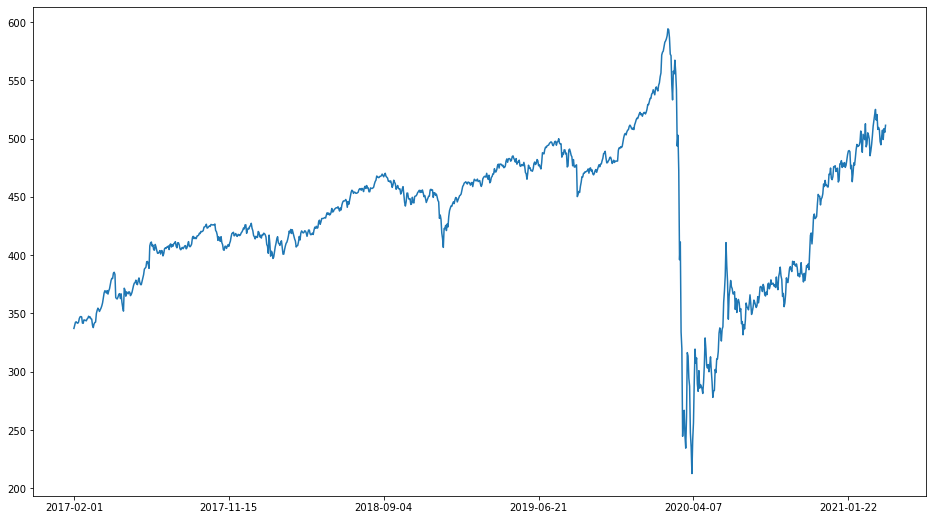

In [30]:
precios[reit.index].sum(axis=1).plot(figsize=(16,9))
plt.show()

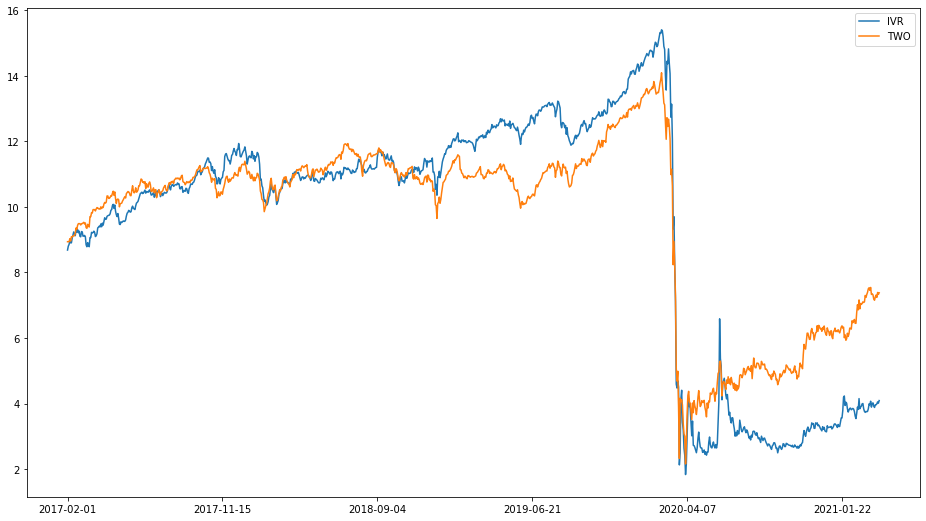

In [36]:
precios[['IVR', 'TWO']].plot(figsize=(16,9))
plt.show()

In [32]:
df[df['MarketCap']>100000].sort_values('Div', ascending = False).head(10)

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
T,-3.86,-4.83,24.95,35.98,0.17,0.57,0.98,25.59,31.52,AT&T Inc,...,"217,305.00",0.07,3.18,9.52,1.22,0.12,0.04,0.78,-3.01,1983-11-21
PM,-3.65,-3.89,56.53,83.00,0.35,1.14,3.71,59.94,78.46,Philip Morris International Inc,...,"137,243.00",0.05,5.18,17.13,NaN,-0.77,0.20,NaN,28.08,2008-03-17
TOT,-5.11,-4.16,26.09,43.80,0.66,1.39,2.91,28.14,43.93,Totalfinaelf S.A.,...,"123,052.00",0.05,1.43,32.55,1.18,0.04,0.02,0.59,-6.05,1991-10-25
IBM,-5.00,-6.46,89.79,143.27,0.36,1.03,5.45,99.61,130.34,International Business Machines,...,"119,054.00",0.05,8.67,15.37,5.79,0.38,0.05,2.58,7.59,1962-01-02
ABBV,-4.07,-5.81,61.23,90.14,0.74,2.53,7.57,64.06,103.68,Abbvie Inc,...,"191,519.00",0.05,10.51,10.30,14.40,1.99,0.13,5.38,10.08,2013-01-02
VZ,-1.49,-2.65,48.19,55.75,0.35,1.70,2.50,47.83,60.45,Verizon Communications Inc,...,"241,362.00",0.04,4.90,11.87,3.50,0.31,0.07,1.65,13.88,1983-11-21
TD,-5.51,-5.68,32.19,54.53,0.62,1.76,3.69,36.78,54.22,Toronto Dominion Bank,...,"119,554.00",0.04,4.17,15.64,1.70,0.12,0.01,0.13,22.16,1996-08-30
PFE,-2.37,-3.30,25.94,33.14,0.50,1.61,2.00,27.04,36.83,Pfizer Inc,...,"202,468.00",0.04,2.72,13.32,3.16,0.24,0.09,0.76,22.95,1972-06-01
AZN,-2.15,-2.88,37.74,47.85,0.43,1.38,3.51,39.30,59.47,Astrazeneca Plc,...,"129,996.00",0.04,2.02,24.61,8.39,0.38,0.08,1.34,12.01,1993-05-12


In [33]:
df.nlargest(10, "Div")

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
AIV,-8.12,-7.25,2.08,4.56,0.96,1.67,0.26,2.16,3.93,Apartment Investment and Management,...,937.03,0.66,1.27,1.94,1.34,-0.01,0.00,2.06,-3.33,1994-07-22
IRCP,-5.65,-4.76,5.12,9.47,1.46,1.78,1.39,3.74,13.25,Irsa Propiedades Ads,...,309.96,0.36,4.33,3.33,0.29,0.02,0.01,0.31,146.40,2003-11-05
TRMD,-0.27,-0.17,6.35,8.08,0.67,0.63,0.56,5.88,11.26,Torm Plc Cl A,...,689.23,0.19,1.19,7.66,0.67,0.08,0.04,0.72,11.79,2018-02-23
MAGS,-3.15,-3.57,1.75,2.43,0.66,1.59,0.23,1.56,2.63,Magal Security Syst,...,103.50,0.18,0.09,49.78,1.17,0.00,0.00,0.00,2.64,1993-03-23
FRO,-0.70,-0.46,5.80,8.08,0.25,0.38,0.77,5.41,9.46,Frontline Ltd,...,"1,453.04",0.17,2.14,3.34,0.87,0.26,0.11,1.23,33.81,2001-08-06
SJT,-4.57,-5.39,1.54,2.37,1.42,2.25,0.41,1.63,3.84,San Juan Basin Royalty Trust,...,191.57,0.16,0.11,36.00,36.68,0.00,0.00,0.00,81.47,1980-10-24
AM,-7.31,-5.24,1.95,4.09,2.03,2.78,1.31,1.66,6.86,Antero Midstream Corp,...,"4,349.39",0.14,0.91,9.92,1.74,0.17,0.08,1.26,-13.60,2017-05-04
USAC,-11.00,-4.53,3.71,13.06,1.91,2.21,1.99,3.94,12.64,USA Compression Partners LP,...,"1,388.98",0.14,-0.22,0.00,4.38,0.04,0.01,4.85,-89.07,2013-01-15
SHLX,-6.71,-3.62,7.39,15.63,0.63,1.08,1.41,7.40,13.79,Shell Midstream Partners LP,...,"5,482.45",0.14,1.27,10.50,8.54,1.89,0.24,4.21,112.89,2014-10-29


In [34]:
df.loc[['SWKS', 'AVGO', 'TMUS', 'QCOM', 'NVDA']].iloc[:,-15:]

,Name,Industry,Last,SIC Description,Sector,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,
SWKS,Skyworks Solutions,Semi Radio Frequency,187.70,NaN,Computers and Technology,"30,987.02",0.01,6.83,26.86,6.67,0.27,0.22,0.00,24.28,1984-09-07
AVGO,Broadcom Ltd,Electronics - Semiconductors,475.95,NaN,Computers and Technology,"194,331.00",0.03,20.08,23.09,7.77,0.38,0.12,1.69,12.39,2009-08-06
TMUS,T-Mobile US,Wireless National,127.65,SIC-4812 Radiotelephone Communications,Utilities,"158,644.00",0.00,4.04,31.01,2.37,0.08,0.03,1.05,4.48,2007-04-19
QCOM,Qualcomm Inc,Wireless Equipment,137.79,SIC-3663 Radio & Tv Broadcasting & Communicati...,Computers and Technology,"156,529.00",0.02,4.51,29.40,20.02,1.05,0.15,2.51,22.09,1991-12-13
NVDA,Nvidia Corp,Semi General,552.47,NaN,Computers and Technology,"342,531.00",0.00,8.14,65.59,18.90,0.35,0.20,0.39,25.98,1999-01-22


In [35]:
df.shape

(3851, 24)